In [1]:
import findspark
findspark.init()
import pyspark
import pyspark.sql
from pyspark import SparkConf
from pyspark import SparkContext
conf = SparkConf()#
conf.set("spark.python.profile", "true")
#conf = sc.getConf()
conf.set( "spark.driver.memory", "4g" )
conf.set( "spark.jars","/Users/crisliu/agile/lib/mongo-hadoop-spark-2.0.2.jar,\
/Users/crisliu/agile/lib/mongo-java-driver-3.4.0.jar,\
/Users/crisliu/agile/lib/elasticsearch-spark-20_2.10-5.0.0-alpha5.jar,\
/Users/crisliu/agile/lib/snappy-java-1.1.2.6.jar,\
/Users/crisliu/agile/lib/lzo-hadoop-1.0.5.jar")
#/Users/crisliu/agile/lib/elasticsearch-hadoop-5.0.0-alpha5.jar"
#conf.set("spark.executor.extraClassPath","~")
sc = SparkContext('local', 'test', conf=conf)
#sc = pyspark.SparkContext()
APP_NAME = "my_script.py"
spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

Chapter 2

In [2]:
import pymongo_spark
# Important: activate pymongo_spark 
pymongo_spark.activate()
csv_lines = sc.textFile("/Users/crisliu/agile/Agile_Data_Code_2/data/example.csv")
data = csv_lines.map(lambda line: line.split(",")) 
schema_data = data.map(
lambda x: {'name': x[0], 'company': x[1], 'title': x[2]} )
schema_data.saveToMongoDB('mongodb://localhost:27017/agile_data_science.executives')

In [4]:
on_time_dataframe = spark.read.parquet('/Users/crisliu/agile/Agile_Data_Code_2/data/on_time_performance.parquet')
on_time_dataframe.count()

5819079

In [5]:
# Note we have to convert the row to a dict to avoid https://jira.mongodb.org/browse/HADOOP-276
as_dict = on_time_dataframe.rdd.map(lambda row: row.asDict())
as_dict.saveToMongoDB('mongodb://localhost:27017/agile_data_science.on_time_performance')

KeyboardInterrupt: 

In [6]:
import time
t0 = time.time()
a = on_time_dataframe.write.format("org.elasticsearch.spark.sql")\
.option("es.resource","agile_data_science/on_time_performance")\
.option("es.batch.size.entries","100")\
.mode("overwrite")
a.save()
print(time.time()-t0)

Py4JJavaError: An error occurred while calling o76.save.
: org.elasticsearch.hadoop.rest.EsHadoopNoNodesLeftException: Connection error (check network and/or proxy settings)- all nodes failed; tried [[127.0.0.1:9200]] 
	at org.elasticsearch.hadoop.rest.NetworkClient.execute(NetworkClient.java:142)
	at org.elasticsearch.hadoop.rest.RestClient.execute(RestClient.java:431)
	at org.elasticsearch.hadoop.rest.RestClient.executeNotFoundAllowed(RestClient.java:439)
	at org.elasticsearch.hadoop.rest.RestClient.delete(RestClient.java:495)
	at org.elasticsearch.hadoop.rest.RestRepository.delete(RestRepository.java:422)
	at org.elasticsearch.spark.sql.ElasticsearchRelation.insert(DefaultSource.scala:481)
	at org.elasticsearch.spark.sql.DefaultSource.createRelation(DefaultSource.scala:76)
	at org.apache.spark.sql.execution.datasources.DataSource.write(DataSource.scala:426)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:215)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)


In [78]:
schema_data.saveAsNewAPIHadoopFile(
  path='-', 
  outputFormatClass="org.elasticsearch.hadoop.mr.EsOutputFormat",
  keyClass="org.apache.hadoop.io.NullWritable", 
  valueClass="org.elasticsearch.hadoop.mr.LinkedMapWritable", 
  conf={ "es.resource" : "agile_data_science/executives" })


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.saveAsNewAPIHadoopFile.
: org.apache.spark.SparkException: RDD element of type java.util.HashMap cannot be used
	at org.apache.spark.api.python.SerDeUtil$.pythonToPairRDD(SerDeUtil.scala:238)
	at org.apache.spark.api.python.PythonRDD$.saveAsNewAPIHadoopFile(PythonRDD.scala:827)
	at org.apache.spark.api.python.PythonRDD.saveAsNewAPIHadoopFile(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)


In [85]:
from pyelasticsearch import ElasticSearch
es = ElasticSearch('http://localhost:9200/')
es.search('name:AA', index='agile_data_science.flights_per_airplane')

ElasticHttpNotFoundError: (404, 'index_not_found_exception')

In [89]:
es.create_index(index='agile_data_science.flights_per_airplane')

{'acknowledged': True, 'shards_acknowledged': True}

In [95]:
es.search('TailNum: N5FNAA', index='agile_data_science.flights_per_airplane')

{'_shards': {'failed': 0, 'successful': 5, 'total': 5},
 'hits': {'hits': [], 'max_score': None, 'total': 0},
 'timed_out': False,
 'took': 2}

In [26]:
on_time_dataframe.take(1)

[Row(Year='2015', Quarter='1', Month='1', DayofMonth='1', DayOfWeek='4', FlightDate='2015-01-01', Carrier='AA', TailNum='N001AA', FlightNum='1519', Origin='DFW', OriginCityName='Dallas/Fort Worth, TX', OriginState='TX', Dest='MEM', DestCityName='Memphis, TN', DestState='TN', DepTime='1342', DepDelay=-3.0, DepDelayMinutes=0, TaxiOut=16.0, TaxiIn=7.0, WheelsOff='1358', WheelsOn='1457', ArrTime='1504', ArrDelay=-6.0, ArrDelayMinutes=0.0, Cancelled=0, Diverted=0, ActualElapsedTime=82.0, AirTime=59.0, Flights=1, Distance=432.0, CarrierDelay=None, WeatherDelay=None, NASDelay=None, SecurityDelay=None, LateAircraftDelay=None, CRSDepTime='1345', CRSArrTime='1510')]

Chapter 5

In [9]:
# Use SQL to look at the total flights by month across 2015
on_time_dataframe.registerTempTable("on_time_dataframe")
total_flights_by_month = spark.sql(
  """SELECT Month, Year, COUNT(*) AS total_flights
  FROM on_time_dataframe
  GROUP BY Year, Month
  ORDER BY Year, Month"""
)

# This map/asDict trick makes the rows print a little prettier. It is optional.
flights_chart_data = total_flights_by_month.rdd.map(lambda row: row.asDict())
flights_chart_data.collect()

# Save chart to MongoDB
import pymongo_spark
pymongo_spark.activate()
flights_chart_data.saveToMongoDB(
  'mongodb://localhost:27017/agile_data_science.flights_by_month'
)


In [12]:
# Filter down to the fields we need to identify and link to a flight
flights = on_time_dataframe.rdd.map(lambda x: 
  (x.Carrier, x.FlightDate, x.FlightNum, x.Origin, x.Dest, x.TailNum)
  )

# Group flights by tail number, sorted by date, then flight number, then origin/dest
flights_per_airplane = flights\
  .map(lambda nameTuple: (nameTuple[5], [nameTuple[0:5]]))\
  .reduceByKey(lambda a, b: a + b)\
  .map(lambda tuple:
      {
        'TailNum': tuple[0], 
        'Flights': sorted(tuple[1], key=lambda x: (x[1], x[2], x[3], x[4]))
      }
    )


# Save to Mongo
#import pymongo_spark
#pymongo_spark.activate()
flights_per_airplane.saveToMongoDB('mongodb://localhost:27017/agile_data_science.flights_per_airplane')
flights_per_airplane.first()

{'Flights': [('AA', '2015-01-02', '1582', 'BOS', 'MIA'),
  ('AA', '2015-01-02', '1582', 'MIA', 'BOS'),
  ('AA', '2015-01-02', '2440', 'MIA', 'BOS'),
  ('AA', '2015-01-03', '1541', 'BOS', 'MIA'),
  ('AA', '2015-01-03', '1605', 'MIA', 'DFW'),
  ('AA', '2015-01-04', '2278', 'DFW', 'MIA'),
  ('AA', '2015-01-05', '1582', 'BOS', 'MIA'),
  ('AA', '2015-01-05', '1582', 'MIA', 'BOS'),
  ('AA', '2015-01-14', '369', 'DFW', 'SAN'),
  ('AA', '2015-01-14', '369', 'SAN', 'DFW'),
  ('AA', '2015-01-15', '2441', 'DFW', 'LAS'),
  ('AA', '2015-01-15', '2441', 'LAS', 'DFW'),
  ('AA', '2015-01-16', '1533', 'BOS', 'MIA'),
  ('AA', '2015-01-16', '1533', 'MIA', 'BOS'),
  ('AA', '2015-01-16', '206', 'DFW', 'MIA'),
  ('AA', '2015-01-18', '2292', 'MIA', 'JFK'),
  ('AA', '2015-01-19', '1275', 'STT', 'JFK'),
  ('AA', '2015-01-19', '1320', 'JFK', 'STT'),
  ('AA', '2015-01-19', '2387', 'JFK', 'MIA'),
  ('AA', '2015-01-20', '1260', 'MIA', 'JFK'),
  ('AA', '2015-01-20', '1646', 'JFK', 'MIA'),
  ('AA', '2015-01-21', '12

In [68]:
# Dump the unneeded fields
tail_numbers = on_time_dataframe.rdd.map(lambda x: x.TailNum)
tail_numbers = tail_numbers.filter(lambda x: x != '')

# distinct() gets us unique tail numbers
unique_tail_numbers = tail_numbers.distinct()

# Store as JSON objects via a dataframe. Repartition to 1 to get 1 json file.
unique_records = unique_tail_numbers.map(lambda x: {'TailNum': x})
unique_records.toDF().repartition(1).write.json("../data/tail_numbers.json")

# Now from bash: ls data/tail_numbers.json/part*


/Users/crisliu/agile/spark/python/pyspark/sql/session.py:336: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [69]:
!cp ../data/tail_numbers.json/part* ../data/tail_numbers.jsonl

In [19]:
unique_records.take(10)

[{'TailNum': 'N3KJAA'},
 {'TailNum': 'N632SW'},
 {'TailNum': 'N537JB'},
 {'TailNum': 'N920DE'},
 {'TailNum': 'N200UU'},
 {'TailNum': 'N138SY'},
 {'TailNum': 'N7740A'},
 {'TailNum': 'N14568'},
 {'TailNum': 'N81449'},
 {'TailNum': 'N5ESAA'}]

Chapter 6

In [23]:
on_time_dataframe

DataFrame[Year: string, Quarter: string, Month: string, DayofMonth: string, DayOfWeek: string, FlightDate: string, Carrier: string, TailNum: string, FlightNum: string, Origin: string, OriginCityName: string, OriginState: string, Dest: string, DestCityName: string, DestState: string, DepTime: string, DepDelay: float, DepDelayMinutes: int, TaxiOut: float, TaxiIn: float, WheelsOff: string, WheelsOn: string, ArrTime: string, ArrDelay: float, ArrDelayMinutes: float, Cancelled: int, Diverted: int, ActualElapsedTime: float, AirTime: float, Flights: int, Distance: float, CarrierDelay: float, WeatherDelay: float, NASDelay: float, SecurityDelay: float, LateAircraftDelay: float, CRSDepTime: string, CRSArrTime: string]

In [25]:
on_time_dataframe.registerTempTable("on_time_performance")

carrier_airplane = spark.sql(
  "SELECT DISTINCT Carrier, TailNum FROM on_time_performance"
  )

# Now we need to store a sorted group for each Carrier, along with a fleet count
airplanes_per_carrier = carrier_airplane.rdd\
  .map(lambda nameTuple: (nameTuple[0], [nameTuple[1]]))\
  .reduceByKey(lambda a, b: a + b)\
  .map(lambda tuple:
      {
        'Carrier': tuple[0], 
        'TailNumbers': sorted(
          filter(
            lambda x: x is not None and x != '', tuple[1] # empty string tail numbers were getting through
            )
          ),
        'FleetCount': len(tuple[1])
      }
    )
airplanes_per_carrier.count() # 14

# Save to Mongo in the airplanes_per_carrier relation
airplanes_per_carrier.saveToMongoDB(
  'mongodb://localhost:27017/agile_data_science.airplanes_per_carrier'
)

In [37]:
#add_name_to_airlines.py
import sys, os, re
carrier_codes = spark.sql(
  "SELECT DISTINCT Carrier FROM on_time_performance"
  )
carrier_codes.collect()

from pyspark.sql.types import StringType, IntegerType
from pyspark.sql.types import StructType, StructField

schema = StructType([
  StructField("ID", IntegerType(), True),  # "ArrDelay":5.0
  StructField("Name", StringType(), True),  # "CRSArrTime":"2015-12-31T03:20:00.000-08:00"
  StructField("Alias", StringType(), True),  # "CRSDepTime":"2015-12-31T03:05:00.000-08:00"
  StructField("IATA", StringType(), True),  # "Carrier":"WN"
  StructField("ICAO", StringType(), True),  # "DayOfMonth":31
  StructField("CallSign", StringType(), True),  # "DayOfWeek":4
  StructField("Country", StringType(), True),  # "DayOfYear":365
  StructField("Active", StringType(), True),  # "DepDelay":14.0
])

airlines = spark.read.format('com.databricks.spark.csv')\
  .options(header='false', nullValue='\\N')\
  .schema(schema)\
  .load('../data/airlines.csv')
airlines.show()

# Is Delta around?
airlines.filter(airlines.IATA == 'DL').show()

# Drop fields except for C1 as name, C3 as carrier code
airlines.registerTempTable("airlines")
airlines = spark.sql("SELECT Name, IATA AS CarrierCode from airlines")

# Join our 14 carrier codes to the airliens table to get our set of airlines
our_airlines = carrier_codes.join(airlines, carrier_codes.Carrier == airlines.CarrierCode)
our_airlines = our_airlines.select('Name', 'CarrierCode')
our_airlines.show()

# Store as JSON objects via a dataframe. Repartition to 1 to get 1 json file.
our_airlines.repartition(1).write.mode("overwrite").json("../data/our_airlines.json")

os.system("cp ../data/our_airlines.json/part* ../data/our_airlines.jsonl")

#wikidata = spark.read.json('data/wikidata-20160404-all.json.bz2')


+---+--------------------+-----+----+----+--------------+--------------+------+
| ID|                Name|Alias|IATA|ICAO|      CallSign|       Country|Active|
+---+--------------------+-----+----+----+--------------+--------------+------+
| -1|             Unknown| null|   -| N/A|          null|          null|     Y|
|  1|      Private flight| null|   -| N/A|          null|          null|     Y|
|  2|         135 Airways| null|null| GNL|       GENERAL| United States|     N|
|  3|       1Time Airline| null|  1T| RNX|       NEXTIME|  South Africa|     Y|
|  4|2 Sqn No 1 Elemen...| null|null| WYT|          null|United Kingdom|     N|
|  5|     213 Flight Unit| null|null| TFU|          null|        Russia|     N|
|  6|223 Flight Unit S...| null|null| CHD|CHKALOVSK-AVIA|        Russia|     N|
|  7|   224th Flight Unit| null|null| TTF|    CARGO UNIT|        Russia|     N|
|  8|         247 Jet Ltd| null|null| TWF|  CLOUD RUNNER|United Kingdom|     N|
|  9|         3D Aviation| null|null| SE

0

In [67]:
on_time_dataframe

DataFrame[Year: string, Quarter: string, Month: string, DayofMonth: string, DayOfWeek: string, FlightDate: string, Carrier: string, TailNum: string, FlightNum: string, Origin: string, OriginCityName: string, OriginState: string, Dest: string, DestCityName: string, DestState: string, DepTime: string, DepDelay: float, DepDelayMinutes: int, TaxiOut: float, TaxiIn: float, WheelsOff: string, WheelsOn: string, ArrTime: string, ArrDelay: float, ArrDelayMinutes: float, Cancelled: int, Diverted: int, ActualElapsedTime: float, AirTime: float, Flights: int, Distance: float, CarrierDelay: float, WeatherDelay: float, NASDelay: float, SecurityDelay: float, LateAircraftDelay: float, CRSDepTime: string, CRSArrTime: string]

In [70]:
# Load the FAA N-Number inquiry records
faa_tail_number_inquiry = spark.read.json('../data/faa_tail_number_inquiry.jsonl')
faa_tail_number_inquiry.show()
# Count the records
faa_tail_number_inquiry.count()
# Load our unique tail numbers
unique_tail_numbers = spark.read.json('../data/tail_numbers.jsonl')
unique_tail_numbers.show()
# Join tail numbers to our inquries
tail_num_plus_inquiry = unique_tail_numbers.join(
  faa_tail_number_inquiry,
  unique_tail_numbers.TailNum == faa_tail_number_inquiry.TailNum,
)
tail_num_plus_inquiry = tail_num_plus_inquiry.drop(unique_tail_numbers.TailNum)
tail_num_plus_inquiry.show()
# Dump extra field and store tail_numbers plus inquiry
tail_num_plus_inquiry.registerTempTable("tail_num_plus_inquiry")
airplanes = spark.sql("""SELECT
  TailNum AS TailNum,
  engine_manufacturer AS EngineManufacturer,
  engine_model AS EngineModel,
  manufacturer AS Manufacturer,
  mfr_year AS ManufacturerYear,
  model AS Model,
  owner AS Owner,
  owner_state AS OwnerState,
  serial_number AS SerialNumber
FROM
  tail_num_plus_inquiry""")
airplanes.repartition(1).write.json('../data/airplanes.json')


+-------+-------------------+------------+--------------------+--------+-----------+--------------------+-------------+-------------+
|TailNum|engine_manufacturer|engine_model|        manufacturer|mfr_year|      model|               owner|  owner_state|serial_number|
+-------+-------------------+------------+--------------------+--------+-----------+--------------------+-------------+-------------+
| N933EV|                 GE| CF34 SERIES|      BOMBARDIER INC|    2005|CL-600-2B19| DELTA AIR LINES INC|      GEORGIA|         8022|
| N917WN|           CFM INTL|  CFM56-7B24|              BOEING|    2008|    737-7H4|SOUTHWEST AIRLINE...|        TEXAS|        36624|
| N438WN|          CFM INTL.|CFM56 SERIES|              BOEING|    2003|    737-7H4|SOUTHWEST AIRLINE...|        TEXAS|        29833|
| N283VA|           CFM INTL| CFM56-5B4/3|              AIRBUS|    2015|   A320-214|  VIRGIN AMERICA INC|   CALIFORNIA|         6787|
| N473UA|           IVCHENKO| AL-25SERIES|    AIRBUS INDUSTRIE

Analyze_airplane.py

In [74]:
airplanes = spark.read.json('../data/airplanes.json')

#
# Who makes the airplanes in the US commercial fleet, as a %
#

# How many airplanes are made by each manufacturer?
airplanes.registerTempTable("airplanes")
manufacturer_counts = spark.sql("""SELECT
  Manufacturer,
  COUNT(*) AS Total
FROM
  airplanes
GROUP BY
  Manufacturer
ORDER BY
  Total DESC"""
)
manufacturer_counts.show(30) # show top 30

# How many airplanes total?
total_airplanes = spark.sql(
  """SELECT
  COUNT(*) AS OverallTotal
  FROM airplanes"""
)
print("Total airplanes: {}".format(total_airplanes.collect()[0].OverallTotal))

mfr_with_totals = manufacturer_counts.join(total_airplanes)
"""mfr_with_totals = mfr_with_totals.rdd.map(
  lambda x: {
    'Manufacturer': x.Manufacturer,
    'Total': x.Total,
    'Percentage': round(
      (
        float(x.Total)/float(x.OverallTotal)
      ) * 100,
      2
    )
  }
)
mfr_with_totals.toDF().show()"""
#
# Same with sub-queries
#
relative_manufacturer_counts = spark.sql("""SELECT
  Manufacturer,
  COUNT(*) AS Total,
  ROUND(
    100 * (
      COUNT(*)/(SELECT COUNT(*) FROM airplanes)
    ),
    2
  ) AS PercentageTotal
FROM
  airplanes
GROUP BY
  Manufacturer
ORDER BY
  Total DESC, Manufacturer
LIMIT 10"""
)
relative_manufacturer_counts.show(30) # show top 30

#
# Now get these things on the web
#
relative_manufacturer_counts = relative_manufacturer_counts.rdd.map(lambda row: row.asDict())
grouped_manufacturer_counts = relative_manufacturer_counts.groupBy(lambda x: 1)

# Save to Mongo in the airplanes_per_carrier relation
#import pymongo_spark
#pymongo_spark.activate()
grouped_manufacturer_counts.saveToMongoDB(
  'mongodb://localhost:27017/agile_data_science.airplane_manufacturer_totals'
)


+--------------------+-----+
|        Manufacturer|Total|
+--------------------+-----+
|              BOEING| 1953|
|              AIRBUS|  519|
|      BOMBARDIER INC|  428|
|    AIRBUS INDUSTRIE|  426|
|             EMBRAER|  330|
|   MCDONNELL DOUGLAS|  116|
|MCDONNELL DOUGLAS...|  103|
|         EMBRAER S A|   43|
|MCDONNELL DOUGLAS...|   14|
|              CESSNA|    9|
|            CANADAIR|    8|
|               BEECH|    6|
|GULFSTREAM AEROSPACE|    5|
|               PIPER|    5|
|  CIRRUS DESIGN CORP|    3|
|RAYTHEON AIRCRAFT...|    2|
|DIAMOND AIRCRAFT ...|    2|
|             DOUGLAS|    1|
|                 DJI|    1|
|          AGUSTA SPA|    1|
|              SOCATA|    1|
|ROBINSON HELICOPT...|    1|
|     LAMBERT RICHARD|    1|
|        GROSS ROBERT|    1|
|                BELL|    1|
|          MARZ BARRY|    1|
|        KILDALL GARY|    1|
|         PAIR MIKE E|    1|
|         LEARJET INC|    1|
|  AVIAT AIRCRAFT INC|    1|
+--------------------+-----+
only showing t

In [102]:
airplanes = spark.read.json("../data/airplanes.json")
#airplanes.show()

airplanes.write.format("org.elasticsearch.spark.sql")\
.option("es.resource","agile_data_science/airplane")\
.mode("overwrite")\
.save()

Py4JJavaError: An error occurred while calling o1148.save.
: org.elasticsearch.hadoop.rest.EsHadoopInvalidRequest: request [/agile_data_science/airplane/_query] contains unrecognized parameter: [q]
null
	at org.elasticsearch.hadoop.rest.RestClient.checkResponse(RestClient.java:475)
	at org.elasticsearch.hadoop.rest.RestClient.executeNotFoundAllowed(RestClient.java:446)
	at org.elasticsearch.hadoop.rest.RestClient.delete(RestClient.java:495)
	at org.elasticsearch.hadoop.rest.RestRepository.delete(RestRepository.java:422)
	at org.elasticsearch.spark.sql.ElasticsearchRelation.insert(DefaultSource.scala:481)
	at org.elasticsearch.spark.sql.DefaultSource.createRelation(DefaultSource.scala:76)
	at org.apache.spark.sql.execution.datasources.DataSource.write(DataSource.scala:426)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:215)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)


In [105]:
conf2 = {"es.resource" : "agile_data_science"}   # assume Elasticsearch is running on localhost defaults
rdd = sc.newAPIHadoopRDD("org.elasticsearch.hadoop.mr.EsInputFormat",\
    "org.apache.hadoop.io.NullWritable", "org.elasticsearch.hadoop.mr.LinkedMapWritable", conf=conf2)
rdd.first()         # the result is a MapWritable that is converted to a Python dict


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.newAPIHadoopRDD.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 206.0 failed 1 times, most recent failure: Lost task 0.0 in stage 206.0 (TID 4629, localhost, executor driver): org.elasticsearch.hadoop.rest.EsHadoopInvalidRequest: request [/agile_data_science/_search] contains unrecognized parameter: [_local]
{"slice":{"id":4,"max":58},"query":{"match_all":{}}}
	at org.elasticsearch.hadoop.rest.RestClient.checkResponse(RestClient.java:475)
	at org.elasticsearch.hadoop.rest.RestClient.execute(RestClient.java:433)
	at org.elasticsearch.hadoop.rest.RestClient.execute(RestClient.java:423)
	at org.elasticsearch.hadoop.rest.RestRepository.scroll(RestRepository.java:363)
	at org.elasticsearch.hadoop.rest.ScrollQuery.hasNext(ScrollQuery.java:92)
	at org.elasticsearch.hadoop.mr.EsInputFormat$EsInputRecordReader.next(EsInputFormat.java:246)
	at org.elasticsearch.hadoop.mr.EsInputFormat$EsInputRecordReader.nextKeyValue(EsInputFormat.java:180)
	at org.apache.spark.rdd.NewHadoopRDD$$anon$1.hasNext(NewHadoopRDD.scala:199)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:39)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:389)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1336)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at scala.collection.AbstractIterator.to(Iterator.scala:1336)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1336)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1336)
	at org.apache.spark.rdd.RDD$$anonfun$take$1$$anonfun$29.apply(RDD.scala:1353)
	at org.apache.spark.rdd.RDD$$anonfun$take$1$$anonfun$29.apply(RDD.scala:1353)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:1944)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:1944)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1918)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1931)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1944)
	at org.apache.spark.rdd.RDD$$anonfun$take$1.apply(RDD.scala:1353)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.take(RDD.scala:1326)
	at org.apache.spark.api.python.SerDeUtil$.pairRDDToPython(SerDeUtil.scala:203)
	at org.apache.spark.api.python.PythonRDD$.newAPIHadoopRDD(PythonRDD.scala:582)
	at org.apache.spark.api.python.PythonRDD.newAPIHadoopRDD(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.elasticsearch.hadoop.rest.EsHadoopInvalidRequest: request [/agile_data_science/_search] contains unrecognized parameter: [_local]
{"slice":{"id":4,"max":58},"query":{"match_all":{}}}
	at org.elasticsearch.hadoop.rest.RestClient.checkResponse(RestClient.java:475)
	at org.elasticsearch.hadoop.rest.RestClient.execute(RestClient.java:433)
	at org.elasticsearch.hadoop.rest.RestClient.execute(RestClient.java:423)
	at org.elasticsearch.hadoop.rest.RestRepository.scroll(RestRepository.java:363)
	at org.elasticsearch.hadoop.rest.ScrollQuery.hasNext(ScrollQuery.java:92)
	at org.elasticsearch.hadoop.mr.EsInputFormat$EsInputRecordReader.next(EsInputFormat.java:246)
	at org.elasticsearch.hadoop.mr.EsInputFormat$EsInputRecordReader.nextKeyValue(EsInputFormat.java:180)
	at org.apache.spark.rdd.NewHadoopRDD$$anon$1.hasNext(NewHadoopRDD.scala:199)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:39)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:389)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1336)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at scala.collection.AbstractIterator.to(Iterator.scala:1336)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1336)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1336)
	at org.apache.spark.rdd.RDD$$anonfun$take$1$$anonfun$29.apply(RDD.scala:1353)
	at org.apache.spark.rdd.RDD$$anonfun$take$1$$anonfun$29.apply(RDD.scala:1353)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:1944)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:1944)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


Chapter 7

# Initialize PySpark

First, we use the findspark package to initialize PySpark.

In [1]:
# Initialize PySpark
APP_NAME = "Debugging Prediction Problems"

# If there is no SparkSession, create the environment
try:
  sc and spark
except NameError as e:
  import findspark
  findspark.init()
  import pyspark
  import pyspark.sql

  sc = pyspark.SparkContext()
  spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

print("PySpark initiated...")

PySpark initiated...


# Hello, World!

Loading data, mapping it and collecting the records into RAM...

In [2]:
# Load the text file using the SparkContext
csv_lines = sc.textFile("../data/example.csv")

# Map the data to split the lines into a list
data = csv_lines.map(lambda line: line.split(","))

# Collect the dataset into local RAM
data.collect()

[['Russell Jurney', 'Relato', 'CEO'],
 ['Florian Liebert', 'Mesosphere', 'CEO'],
 ['Don Brown', 'Rocana', 'CIO'],
 ['Steve Jobs', 'Apple', 'CEO'],
 ['Donald Trump', 'The Trump Organization', 'CEO'],
 ['Russell Jurney', 'Data Syndrome', 'Principal Consultant']]

# Creating Objects from CSV

Using a function with a map operation to create objects (dicts) as records...

In [3]:
# Turn the CSV lines into objects
def csv_to_record(line):
  parts = line.split(",")
  record = {
    "name": parts[0],
    "company": parts[1],
    "title": parts[2]
  }
  return record

# Apply the function to every record
records = csv_lines.map(csv_to_record)

# Inspect the first item in the dataset
records.first()

{'company': 'Relato', 'name': 'Russell Jurney', 'title': 'CEO'}

# GroupBy

Using the groupBy operator to count the number of jobs per person...

In [4]:
# Group the records by the name of the person
grouped_records = records.groupBy(lambda x: x["name"])

# Show the first group
grouped_records.first()

# Count the groups
job_counts = grouped_records.map(
  lambda x: {
    "name": x[0],
    "job_count": len(x[1])
  }
)

job_counts.first()

job_counts.collect()

[{'job_count': 1, 'name': 'Florian Liebert'},
 {'job_count': 1, 'name': 'Don Brown'},
 {'job_count': 2, 'name': 'Russell Jurney'},
 {'job_count': 1, 'name': 'Donald Trump'},
 {'job_count': 1, 'name': 'Steve Jobs'}]

# Map vs FlatMap

Understanding the difference between the map and flatmap operators...

In [5]:
# Compute a relation of words by line
words_by_line = csv_lines\
  .map(lambda line: line.split(","))

print(words_by_line.collect())

# Compute a relation of words
flattened_words = csv_lines\
  .map(lambda line: line.split(","))\
  .flatMap(lambda x: x)

flattened_words.collect()

[['Russell Jurney', 'Relato', 'CEO'], ['Florian Liebert', 'Mesosphere', 'CEO'], ['Don Brown', 'Rocana', 'CIO'], ['Steve Jobs', 'Apple', 'CEO'], ['Donald Trump', 'The Trump Organization', 'CEO'], ['Russell Jurney', 'Data Syndrome', 'Principal Consultant']]


['Russell Jurney',
 'Relato',
 'CEO',
 'Florian Liebert',
 'Mesosphere',
 'CEO',
 'Don Brown',
 'Rocana',
 'CIO',
 'Steve Jobs',
 'Apple',
 'CEO',
 'Donald Trump',
 'The Trump Organization',
 'CEO',
 'Russell Jurney',
 'Data Syndrome',
 'Principal Consultant']

# Creating Rows

Creating `pyspark.sql.Rows` out of your data so you can create DataFrames...

In [6]:
from pyspark.sql import Row

# Convert the CSV into a pyspark.sql.Row
def csv_to_row(line):
  parts = line.split(",")
  row = Row(
    name=parts[0],
    company=parts[1],
    title=parts[2]
  )
  return row

# Apply the function to get rows in an RDD
rows = csv_lines.map(csv_to_row)

# Creating `DataFrames` from `RDDs`

Using the `RDD.toDF()` method to create a dataframe, registering the `DataFrame` as a temporary table with Spark SQL, and counting the jobs per person using Spark SQL.

In [7]:
# Convert to a pyspark.sql.DataFrame
rows_df = rows.toDF()

# Register the DataFrame for Spark SQL
rows_df.registerTempTable("executives")

# Generate a new DataFrame with SQL using the SparkSession
job_counts = spark.sql("""
SELECT
  name,
  COUNT(*) AS total
  FROM executives
  GROUP BY name
""")
job_counts.show()

# Go back to an RDD
job_counts.rdd.collect()

+---------------+-----+
|           name|total|
+---------------+-----+
|   Donald Trump|    1|
|Florian Liebert|    1|
|      Don Brown|    1|
| Russell Jurney|    2|
|     Steve Jobs|    1|
+---------------+-----+



[Row(name='Donald Trump', total=1),
 Row(name='Florian Liebert', total=1),
 Row(name='Don Brown', total=1),
 Row(name='Russell Jurney', total=2),
 Row(name='Steve Jobs', total=1)]

# Loading and Inspecting Parquet Files

Using the `SparkSession` to load files as `DataFrames` and inspecting their contents...

In [8]:
# Load the parquet file containing flight delay records
on_time_dataframe = spark.read.parquet('../data/on_time_performance.parquet')

# Register the data for Spark SQL
on_time_dataframe.registerTempTable("on_time_performance")

# Check out the columns
on_time_dataframe.columns

# Check out some data
on_time_dataframe\
  .select("FlightDate", "TailNum", "Origin", "Dest", "Carrier", "DepDelay", "ArrDelay")\
  .show()

# Trim the fields and keep the result
trimmed_on_time = on_time_dataframe\
  .select(
    "FlightDate",
    "TailNum",
    "Origin",
    "Dest",
    "Carrier",
    "DepDelay",
    "ArrDelay"
  )

# Sample 0.01% of the data and show
trimmed_on_time.sample(False, 0.0001).show()

+----------+-------+------+----+-------+--------+--------+
|FlightDate|TailNum|Origin|Dest|Carrier|DepDelay|ArrDelay|
+----------+-------+------+----+-------+--------+--------+
|2015-01-01| N001AA|   DFW| MEM|     AA|    -3.0|    -6.0|
|2015-01-01| N001AA|   MEM| DFW|     AA|    -4.0|    -9.0|
|2015-01-01| N002AA|   ORD| DFW|     AA|     0.0|    26.0|
|2015-01-01| N003AA|   DFW| ATL|     AA|   100.0|   112.0|
|2015-01-01| N003AA|   DFW| HDN|     AA|    78.0|    78.0|
|2015-01-01| N003AA|   HDN| DFW|     AA|   332.0|   336.0|
|2015-01-01| N004AA|   JAC| DFW|     AA|    -4.0|    21.0|
|2015-01-01| N005AA|   EGE| ORD|     AA|    null|    null|
|2015-01-01| N005AA|   ORD| EGE|     AA|    null|    null|
|2015-01-01| N005AA|   DFW| ORD|     AA|    null|    null|
|2015-01-01| N006AA|   DFW| ATL|     AA|    null|    null|
|2015-01-01| N006AA|   ATL| DFW|     AA|    -5.0|     1.0|
|2015-01-01| N006AA|   DFW| ATL|     AA|    -4.0|   -11.0|
|2015-01-01| N007AA|   DFW| ATL|     AA|    76.0|    86.

# Calculating Histograms

Using `RDDs` to calculate histograms buckets and values...

In [10]:
# Compute a histogram of departure delays
on_time_dataframe\
  .select("DepDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram(10)

([-82.0,
  125.0,
  332.0,
  539.0,
  746.0,
  953.0,
  1160.0,
  1367.0,
  1574.0,
  1781.0,
  1988.0],
 [11247596, 201786, 12808, 2026, 972, 422, 152, 68, 18, 4])

# Visualizing Histograms

Using pyplot to visualize histograms...

<Container object of 13 artists>

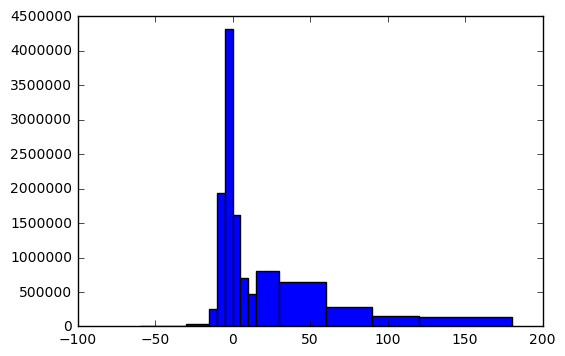

In [14]:
%matplotlib inline

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Function to plot a histogram using pyplot
def create_hist(rdd_histogram_data):
  """Given an RDD.histogram, plot a pyplot histogram"""
  heights = np.array(rdd_histogram_data[1])
  full_bins = rdd_histogram_data[0]
  mid_point_bins = full_bins[:-1]
  widths = [abs(i - j) for i, j in zip(full_bins[:-1], full_bins[1:])]
  bar = plt.bar(mid_point_bins, heights, width=widths, color='b')
  return bar

# Compute a histogram of departure delays
departure_delay_histogram = on_time_dataframe\
  .select("DepDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram([-60,-30,-15,-10,-5,0,5,10,15,30,60,90,120,180])

create_hist(departure_delay_histogram)

# Counting Airplanes in the US Fleet

In [12]:
# Dump the unneeded fields
tail_numbers = on_time_dataframe.rdd.map(lambda x: x.TailNum)
tail_numbers = tail_numbers.filter(lambda x: x != '')

# distinct() gets us unique tail numbers
unique_tail_numbers = tail_numbers.distinct()

# now we need a count() of unique tail numbers
airplane_count = unique_tail_numbers.count()
print("Total airplanes: {}".format(airplane_count))

Total airplanes: 4898


# Counting the Total Flights Per Month

In [15]:
# Use SQL to look at the total flights by month across 2015
on_time_dataframe.registerTempTable("on_time_dataframe")
total_flights_by_month = spark.sql(
  """SELECT Month, Year, COUNT(*) AS total_flights
  FROM on_time_dataframe
  GROUP BY Year, Month
  ORDER BY Year, Month"""
)

# This map/asDict trick makes the rows print a little prettier. It is optional.
flights_chart_data = total_flights_by_month.rdd.map(lambda row: row.asDict())
flights_chart_data.collect()

[{'Month': '1', 'Year': '2015', 'total_flights': 939936},
 {'Month': '10', 'Year': '2015', 'total_flights': 972330},
 {'Month': '11', 'Year': '2015', 'total_flights': 935944},
 {'Month': '12', 'Year': '2015', 'total_flights': 958460},
 {'Month': '2', 'Year': '2015', 'total_flights': 858382},
 {'Month': '3', 'Year': '2015', 'total_flights': 1008624},
 {'Month': '4', 'Year': '2015', 'total_flights': 970302},
 {'Month': '5', 'Year': '2015', 'total_flights': 993986},
 {'Month': '6', 'Year': '2015', 'total_flights': 1007794},
 {'Month': '7', 'Year': '2015', 'total_flights': 1041436},
 {'Month': '8', 'Year': '2015', 'total_flights': 1021072},
 {'Month': '9', 'Year': '2015', 'total_flights': 929892}]

# Using `RDDs` and Map/Reduce to Prepare a Complex Record

In [16]:
# Filter down to the fields we need to identify and link to a flight
flights = on_time_dataframe.rdd.map(lambda x: 
  (x.Carrier, x.FlightDate, x.FlightNum, x.Origin, x.Dest, x.TailNum)
  )

# Group flights by tail number, sorted by date, then flight number, then origin/dest
flights_per_airplane = flights\
  .map(lambda nameTuple: (nameTuple[5], [nameTuple[0:5]]))\
  .reduceByKey(lambda a, b: a + b)\
  .map(lambda tuple:
      {
        'TailNum': tuple[0], 
        'Flights': sorted(tuple[1], key=lambda x: (x[1], x[2], x[3], x[4]))
      }
    )
flights_per_airplane.first()

{'Flights': [('UA', '2015-09-05', '1132', 'DEN', 'LAX'),
  ('UA', '2015-09-05', '1132', 'DEN', 'LAX'),
  ('UA', '2015-09-05', '1169', 'IAH', 'LAX'),
  ('UA', '2015-09-05', '1169', 'IAH', 'LAX'),
  ('UA', '2015-09-05', '1804', 'LAX', 'DEN'),
  ('UA', '2015-09-05', '1804', 'LAX', 'DEN'),
  ('UA', '2015-09-06', '1977', 'LAX', 'IAH'),
  ('UA', '2015-09-06', '1977', 'LAX', 'IAH'),
  ('UA', '2015-09-08', '1423', 'IAH', 'LAX'),
  ('UA', '2015-09-08', '1423', 'IAH', 'LAX'),
  ('UA', '2015-09-08', '1693', 'LAX', 'IAH'),
  ('UA', '2015-09-08', '1693', 'LAX', 'IAH'),
  ('UA', '2015-09-09', '1614', 'IAH', 'SFO'),
  ('UA', '2015-09-09', '1614', 'IAH', 'SFO'),
  ('UA', '2015-09-09', '1937', 'SFO', 'IAH'),
  ('UA', '2015-09-09', '1937', 'SFO', 'IAH'),
  ('UA', '2015-09-10', '1169', 'IAH', 'LAX'),
  ('UA', '2015-09-10', '1169', 'IAH', 'LAX'),
  ('UA', '2015-09-10', '1631', 'DEN', 'LAX'),
  ('UA', '2015-09-10', '1631', 'DEN', 'LAX'),
  ('UA', '2015-09-10', '1653', 'LAX', 'DEN'),
  ('UA', '2015-09-10', 

# Counting Late Flights

In [ ]:
total_flights = on_time_dataframe.count()

# Flights that were late leaving...
late_departures = on_time_dataframe.filter(
  on_time_dataframe.DepDelayMinutes > 0
)
total_late_departures = late_departures.count()
print(total_late_departures)

# Flights that were late arriving...
late_arrivals = on_time_dataframe.filter(
  on_time_dataframe.ArrDelayMinutes > 0
)
total_late_arrivals = late_arrivals.count()
print(total_late_arrivals)

# Get the percentage of flights that are late, rounded to 1 decimal place
pct_late = round((total_late_arrivals / (total_flights * 1.0)) * 100, 1)

# Counting Flights with Hero Captains

"Hero Captains" are those that depart late but make up time in the air and arrive on time or early.

In [ ]:
# Flights that left late but made up time to arrive on time...
on_time_heros = on_time_dataframe.filter(
  (on_time_dataframe.DepDelayMinutes > 0)
  &
  (on_time_dataframe.ArrDelayMinutes <= 0)
)
total_on_time_heros = on_time_heros.count()
print(total_on_time_heros)

# Printing Our Results

In [20]:
print("Total flights:   {:,}".format(total_flights))
print("Late departures: {:,}".format(total_late_departures))
print("Late arrivals:   {:,}".format(total_late_arrivals))
print("Recoveries:      {:,}".format(total_on_time_heros))
print("Percentage Late: {}%".format(pct_late))

Total flights:   11,638,158
Late departures: 4,251,236
Late arrivals:   4,173,792
Recoveries:      1,213,804
Percentage Late: 35.9%


# Computing the Average Lateness Per Flights

In [21]:
# Get the average minutes late departing and arriving
spark.sql("""
SELECT
  ROUND(AVG(DepDelay),1) AS AvgDepDelay,
  ROUND(AVG(ArrDelay),1) AS AvgArrDelay
FROM on_time_performance
"""
).show()

+-----------+-----------+
|AvgDepDelay|AvgArrDelay|
+-----------+-----------+
|        9.4|        4.4|
+-----------+-----------+



# Inspecting Late Flights

In [22]:
# Why are flights late? Lets look at some delayed flights and the delay causes
late_flights = spark.sql("""
SELECT
  ArrDelayMinutes,
  WeatherDelay,
  CarrierDelay,
  NASDelay,
  SecurityDelay,
  LateAircraftDelay
FROM
  on_time_performance
WHERE
  WeatherDelay IS NOT NULL
  OR
  CarrierDelay IS NOT NULL
  OR
  NASDelay IS NOT NULL
  OR
  SecurityDelay IS NOT NULL
  OR
  LateAircraftDelay IS NOT NULL
ORDER BY
  FlightDate
""")
late_flights.sample(False, 0.01).show()

+---------------+------------+------------+--------+-------------+-----------------+
|ArrDelayMinutes|WeatherDelay|CarrierDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+---------------+------------+------------+--------+-------------+-----------------+
|           25.0|         0.0|        25.0|     0.0|          0.0|              0.0|
|          147.0|         0.0|        20.0|     0.0|          0.0|            127.0|
|           17.0|         0.0|         0.0|    17.0|          0.0|              0.0|
|           18.0|         0.0|         0.0|    18.0|          0.0|              0.0|
|           47.0|         0.0|         0.0|    47.0|          0.0|              0.0|
|          235.0|         0.0|         0.0|     0.0|          0.0|            235.0|
|           23.0|         0.0|        23.0|     0.0|          0.0|              0.0|
|           23.0|         0.0|         1.0|    17.0|          0.0|              5.0|
|           28.0|         0.0|         0.0|    28.0|          0.0

# Determining Why Flights Are Late

In [23]:
# Calculate the percentage contribution to delay for each source
total_delays = spark.sql("""
SELECT
  ROUND(SUM(WeatherDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_weather_delay,
  ROUND(SUM(CarrierDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_carrier_delay,
  ROUND(SUM(NASDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_nas_delay,
  ROUND(SUM(SecurityDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_security_delay,
  ROUND(SUM(LateAircraftDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_late_aircraft_delay
FROM on_time_performance
""")
total_delays.show()

+-----------------+-----------------+-------------+------------------+-----------------------+
|pct_weather_delay|pct_carrier_delay|pct_nas_delay|pct_security_delay|pct_late_aircraft_delay|
+-----------------+-----------------+-------------+------------------+-----------------------+
|              4.5|             29.2|         20.7|               0.1|                   36.1|
+-----------------+-----------------+-------------+------------------+-----------------------+



# Computing a Histogram of Weather Delayed Flights

In [26]:
# Eyeball the first to define our buckets
weather_delay_histogram = on_time_dataframe\
  .select("WeatherDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram([1, 5, 10, 15, 30, 60, 120, 240, 480, 720, 24*60.0])
print(weather_delay_histogram)

([1, 5, 10, 15, 30, 60, 120, 240, 480, 720, 1440.0], [10872, 15336, 13272, 32014, 27138, 18884, 9196, 2272, 304, 144])


<Container object of 8 artists>

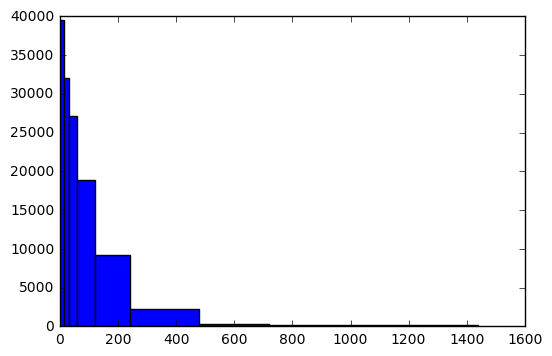

In [25]:
create_hist(weather_delay_histogram)

# Preparing a Histogram for Visualization by d3.js

In [3]:
# Transform the data into something easily consumed by d3
def histogram_to_publishable(histogram):
  record = {'key': 1, 'data': []}
  for label, value in zip(histogram[0], histogram[1]):
    record['data'].append(
      {
        'label': label,
        'value': value
      }
    )
  return record

# Recompute the weather histogram with a filter for on-time flights
weather_delay_histogram = on_time_dataframe\
  .filter(
    (on_time_dataframe.WeatherDelay != None)
    &
    (on_time_dataframe.WeatherDelay > 0)
  )\
  .select("WeatherDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram([0, 15, 30, 60, 120, 240, 480, 720, 24*60.0])
print(weather_delay_histogram)

record = histogram_to_publishable(weather_delay_histogram)
record

NameError: name 'on_time_dataframe' is not defined

# Building a Classifier Model to Predict Flight Delays

## Loading Our Data

In [31]:
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType, DateType, TimestampType
from pyspark.sql.types import StructType, StructField
from pyspark.sql.functions import udf

schema = StructType([
  StructField("ArrDelay", DoubleType(), True),     # "ArrDelay":5.0
  StructField("CRSArrTime", TimestampType(), True),    # "CRSArrTime":"2015-12-31T03:20:00.000-08:00"
  StructField("CRSDepTime", TimestampType(), True),    # "CRSDepTime":"2015-12-31T03:05:00.000-08:00"
  StructField("Carrier", StringType(), True),     # "Carrier":"WN"
  StructField("DayOfMonth", IntegerType(), True), # "DayOfMonth":31
  StructField("DayOfWeek", IntegerType(), True),  # "DayOfWeek":4
  StructField("DayOfYear", IntegerType(), True),  # "DayOfYear":365
  StructField("DepDelay", DoubleType(), True),     # "DepDelay":14.0
  StructField("Dest", StringType(), True),        # "Dest":"SAN"
  StructField("Distance", DoubleType(), True),     # "Distance":368.0
  StructField("FlightDate", DateType(), True),    # "FlightDate":"2015-12-30T16:00:00.000-08:00"
  StructField("FlightNum", StringType(), True),   # "FlightNum":"6109"
  StructField("Origin", StringType(), True),      # "Origin":"TUS"
])

features = spark.read.json(
  "../data/simple_flight_delay_features.jsonl.bz2",
  schema=schema
)
features.first()

Row(ArrDelay=13.0, CRSArrTime=datetime.datetime(2015, 1, 1, 10, 10), CRSDepTime=datetime.datetime(2015, 1, 1, 7, 30), Carrier='AA', DayOfMonth=1, DayOfWeek=4, DayOfYear=1, DepDelay=14.0, Dest='DFW', Distance=569.0, FlightDate=datetime.date(2014, 12, 31), FlightNum='1024', Origin='ABQ')

## Check Data for Nulls

In [32]:
#
# Check for nulls in features before using Spark ML
#
null_counts = [(column, features.where(features[column].isNull()).count()) for column in features.columns]
cols_with_nulls = filter(lambda x: x[1] > 0, null_counts)
print(list(cols_with_nulls))

[]


## Add a Route Column

Demonstrating the addition of a feature to our model...

In [33]:
#
# Add a Route variable to replace FlightNum
#
from pyspark.sql.functions import lit, concat

features_with_route = features.withColumn(
  'Route',
  concat(
    features.Origin,
    lit('-'),
    features.Dest
  )
)
features_with_route.select("Origin", "Dest", "Route").show(5)

+------+----+-------+
|Origin|Dest|  Route|
+------+----+-------+
|   ABQ| DFW|ABQ-DFW|
|   ABQ| DFW|ABQ-DFW|
|   ABQ| DFW|ABQ-DFW|
|   ATL| DFW|ATL-DFW|
|   ATL| DFW|ATL-DFW|
+------+----+-------+
only showing top 5 rows



## Bucketizing ArrDelay into ArrDelayBucket

In [34]:
#
# Use pysmark.ml.feature.Bucketizer to bucketize ArrDelay
#
from pyspark.ml.feature import Bucketizer

splits = [-float("inf"), -15.0, 0, 30.0, float("inf")]
bucketizer = Bucketizer(
  splits=splits,
  inputCol="ArrDelay",
  outputCol="ArrDelayBucket"
)
ml_bucketized_features = bucketizer.transform(features_with_route)

# Check the buckets out
ml_bucketized_features.select("ArrDelay", "ArrDelayBucket").show()

+--------+--------------+
|ArrDelay|ArrDelayBucket|
+--------+--------------+
|    13.0|           2.0|
|    17.0|           2.0|
|    36.0|           3.0|
|   -21.0|           0.0|
|   -14.0|           1.0|
|    16.0|           2.0|
|    -7.0|           1.0|
|    13.0|           2.0|
|    25.0|           2.0|
|    58.0|           3.0|
|    14.0|           2.0|
|     1.0|           2.0|
|   -29.0|           0.0|
|   -10.0|           1.0|
|    -3.0|           1.0|
|    -8.0|           1.0|
|    -1.0|           1.0|
|   -14.0|           1.0|
|   -16.0|           0.0|
|    18.0|           2.0|
+--------+--------------+
only showing top 20 rows



## Indexing Our String Fields into Numeric Fields

In [35]:
#
# Extract features tools in with pyspark.ml.feature
#
from pyspark.ml.feature import StringIndexer, VectorAssembler

# Turn category fields into categoric feature vectors, then drop intermediate fields
for column in ["Carrier", "DayOfMonth", "DayOfWeek", "DayOfYear",
               "Origin", "Dest", "Route"]:
  string_indexer = StringIndexer(
    inputCol=column,
    outputCol=column + "_index"
  )
  ml_bucketized_features = string_indexer.fit(ml_bucketized_features)\
                                          .transform(ml_bucketized_features)

# Check out the indexes
ml_bucketized_features.show(6)

+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+----------------+---------------+---------------+------------+----------+-----------+
|ArrDelay|          CRSArrTime|          CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|  Route|ArrDelayBucket|Carrier_index|DayOfMonth_index|DayOfWeek_index|DayOfYear_index|Origin_index|Dest_index|Route_index|
+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+----------------+---------------+---------------+------------+----------+-----------+
|    13.0|2015-01-01 10:10:...|2015-01-01 07:30:...|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1024|   ABQ|ABQ-DFW|           2.0|          2.0|            25.0|         

## Combining Numeric Fields into a Single Vector

In [36]:
# Handle continuous, numeric fields by combining them into one feature vector
numeric_columns = ["DepDelay", "Distance"]
index_columns = ["Carrier_index", "DayOfMonth_index",
                   "DayOfWeek_index", "DayOfYear_index", "Origin_index",
                   "Origin_index", "Dest_index", "Route_index"]
vector_assembler = VectorAssembler(
  inputCols=numeric_columns + index_columns,
  outputCol="Features_vec"
)
final_vectorized_features = vector_assembler.transform(ml_bucketized_features)

# Drop the index columns
for column in index_columns:
  final_vectorized_features = final_vectorized_features.drop(column)

# Check out the features
final_vectorized_features.show()

+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+
|ArrDelay|          CRSArrTime|          CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|  Route|ArrDelayBucket|        Features_vec|
+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+
|    13.0|2015-01-01 10:10:...|2015-01-01 07:30:...|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1024|   ABQ|ABQ-DFW|           2.0|[14.0,569.0,2.0,2...|
|    17.0|2015-01-01 02:15:...|2014-12-31 23:25:...|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1184|   ABQ|ABQ-DFW|           2.0|[14.0,569.0,2.0,2...|
|    36.0|2015-01-01 03:45:...|2015-01-01 01:00:...|     AA|     

## Training Our Model in an Experimental Setup

In [37]:
#
# Cross validate, train and evaluate classifier
#

# Test/train split
training_data, test_data = final_vectorized_features.randomSplit([0.7, 0.3])

# Instantiate and fit random forest classifier
from pyspark.ml.classification import RandomForestClassifier
rfc = RandomForestClassifier(
  featuresCol="Features_vec",
  labelCol="ArrDelayBucket",
  maxBins=4657,
  maxMemoryInMB=1024
)
model = rfc.fit(training_data)

# Evaluate model using test data
predictions = model.transform(test_data)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="ArrDelayBucket", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = {}".format(accuracy))

# Check a sample
predictions.sample(False, 0.001, 18).orderBy("CRSDepTime").show(6)

Accuracy = 0.5965632172973679
+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+--------------------+--------------------+----------+
|ArrDelay|          CRSArrTime|          CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|  Route|ArrDelayBucket|        Features_vec|       rawPrediction|         probability|prediction|
+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+--------------------+--------------------+----------+
|   -11.0|2014-12-31 22:13:...|2014-12-31 21:10:...|     AA|         1|        4|        1|    -3.0| MIA|   192.0|2014-12-31|     1323|   MCO|MCO-MIA|           1.0|[-3.0,192.0,2.0,2...|[3.15496188966384...|[0.15774809448319...|       1.0|
|    -3.0|